In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
from mecab import MeCab
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request


In [2]:
raw = pd.read_csv('./Training/merged_data.csv')
df = raw.copy()

In [3]:
list_index = df[df.summary.duplicated()].index

In [4]:
df.head()

,passage,summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전..."
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...


In [5]:
list_index

Int64Index([   455,   3569,   3570,   3571,   3572,   3573,   3574,   3575,
              3576,  10635,
            ...
            157796, 157797, 158246, 158248, 158249, 158256, 158299, 158301,
            158302, 158303],
           dtype='int64', length=1533)

In [6]:
for index in list_index:
    df = df.drop(index)

In [7]:
df.isnull().sum()

passage    0
summary    0
dtype: int64

In [8]:
# 불용어(stopwords) 로드
stop_words = set()
with open("./stopwords2.txt", 'r', encoding='utf-8') as f:
    for word in f.readlines():
        stop_words.add(word.strip())

# 형태소 분석기 초기화
mecab = MeCab()


In [9]:
def preprocess_text(text):
    token = mecab.morphs(text)
    return ' '.join(token)

In [10]:
df['PreprocessedText'] = df['passage'].apply(preprocess_text)

In [11]:
df['Pred_summary'] = df['summary'].apply(preprocess_text)

In [12]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = re.sub(r"/([^)]*/)", "", sentence)  # 괄호로 닫힌 문자열 제거 Ex) 가나다 (abc) -> 가나다
    sentence = re.sub('"', "", sentence)  # 쌍따옴표 " 제거
    sentence = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ", sentence)  # 한글과 영어, 숫자를 제외한 문자 공백으로 변환
    sentence = re.sub(" +", " ", sentence)

    # 불용어 제거
    if remove_stopwords:
        sentence = ' '.join(word for word in sentence.split() if word not in stop_words and len(word) > 1)
    else:
        sentence = ' '.join(word for word in sentence.split() if len(word) > 1)
    return sentence

In [13]:
df.head()

,passage,summary,PreprocessedText,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 의 국가 가 직면 하 는 위기 는 전통 사회 의 그것 과 위기 의 규모 뿐 만...,현대 사회 에서 발생 하 는 다양 하 고 복잡 한 위기 는 과거 와 다르 게 국가 ...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 나 불량 수산 식품 파동 등 의 인위 적 재난 이 수산 분야 피해 로 이어...,수산 분야 의 인위 적 재난 시수 산물 수급 문제 로 생산자 들 의 매출 이 크 게...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,하지만 이 와 반 대로 MG 파동 이후 기간 ( 2005 . 10 ～ 2011 . ...,MG 파동 이후 에 는 양식 송어 의 생산량 의 증가 가 통계 적 유의 성 을 갖 ...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,그러나 사회 적 이슈 가 발생 하 였을 경우 에 전문 적 으로 이러 한 정보 를 수...,사회 적 이슈 발생 시 전문 적 으로 정보 수집 및 분석 을 하 는 관측 시스템 이...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,네 번 째 는 공급 감소 로 국내 물량 이 부족 하 게 되 면 유통 질서 가 왜곡 ...,일부 경우 에서 의 유통 질서 혼란 을 방지 하 기 위해 거래 형태 의 변형 이 필...


In [14]:
df['PreprocessedText'] = df['PreprocessedText'].apply(preprocess_sentence)

In [15]:
df.head()

,passage,summary,PreprocessedText,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 사뭇 다르 다고 현대 사...,현대 사회 에서 발생 하 는 다양 하 고 복잡 한 위기 는 과거 와 다르 게 국가 ...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 의 인위 적 재난 시수 산물 수급 문제 로 생산자 들 의 매출 이 크 게...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 나타났 기간 지날수록 양...,MG 파동 이후 에 는 양식 송어 의 생산량 의 증가 가 통계 적 유의 성 을 갖 ...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 이러 정보 수집 분석 관측 시스템 존재 는다고 일본...,사회 적 이슈 발생 시 전문 적 으로 정보 수집 및 분석 을 하 는 관측 시스템 이...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 에서 의 유통 질서 혼란 을 방지 하 기 위해 거래 형태 의 변형 이 필...


In [16]:
df['Pred_summary'] = df['Pred_summary'].apply(preprocess_sentence)

In [17]:
df.rename(columns={'PreprocessedText': 'Pred_Text'}, inplace=True)


In [18]:
df.head()

,passage,summary,Pred_Text,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 사뭇 다르 다고 현대 사...,현대 사회 발생 다양 복잡 위기 과거 다르 국가 재난 이어질 으므로 국가 신속 대책...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 나타났 기간 지날수록 양...,파동 이후 양식 송어 생산량 증가 통계 유의 드러났 통해 파동 이후 양식 송어 생산...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 이러 정보 수집 분석 관측 시스템 존재 는다고 일본...,사회 이슈 발생 전문 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 대책 ...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시장 왜...


In [19]:
df.replace('', np.nan, inplace=True)
print(df.isnull().sum())

passage         0
summary         0
Pred_Text       5
Pred_summary    2
dtype: int64


In [20]:
df.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 158464


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 255
텍스트의 평균 길이 : 90.24465493739903
요약의 최소 길이 : 1
요약의 최대 길이 : 82
요약의 평균 길이 : 26.062626211631663


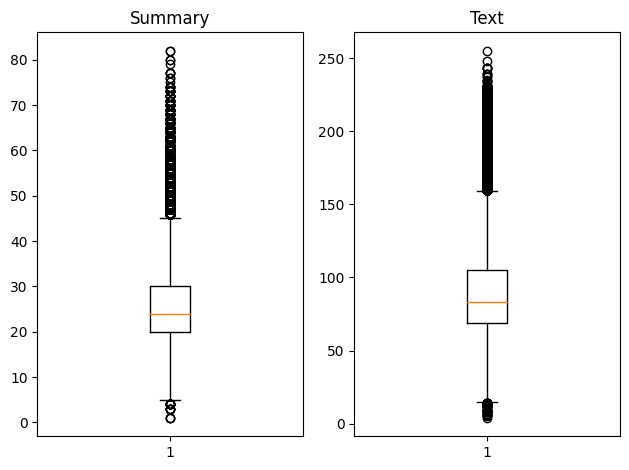

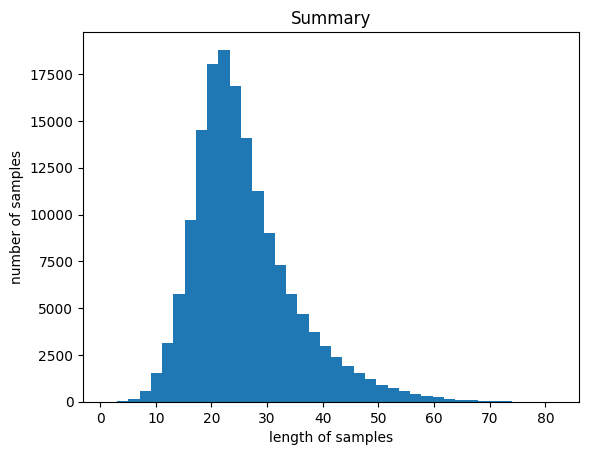

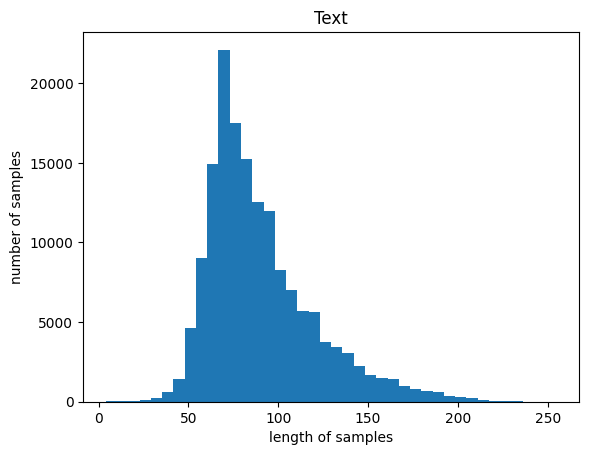

In [21]:
text_len = [len(s.split()) for s in df['Pred_Text']]
summary_len = [len(s.split()) for s in df['Pred_summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
text_max_len = 160
summary_max_len = 50

In [23]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [24]:
below_threshold_len(text_max_len, df['Pred_Text'])


전체 샘플 중 길이가 160 이하인 샘플의 비율: 0.9646922960420032


In [25]:
below_threshold_len(summary_max_len, df['Pred_summary'])


전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9807905896607432


In [26]:
df = df[df['Pred_Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df = df[df['Pred_summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 152075


In [27]:
df.head()

,passage,summary,Pred_Text,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 사뭇 다르 다고 현대 사...,현대 사회 발생 다양 복잡 위기 과거 다르 국가 재난 이어질 으므로 국가 신속 대책...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 나타났 기간 지날수록 양...,파동 이후 양식 송어 생산량 증가 통계 유의 드러났 통해 파동 이후 양식 송어 생산...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 이러 정보 수집 분석 관측 시스템 존재 는다고 일본...,사회 이슈 발생 전문 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 대책 ...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시장 왜...


In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df['decoder_input'] = df['Pred_summary'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['Pred_summary'].apply(lambda x : x + ' eostoken')
df.head()


,passage,summary,Pred_Text,Pred_summary,decoder_input,decoder_target
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 사뭇 다르 다고 현대 사...,현대 사회 발생 다양 복잡 위기 과거 다르 국가 재난 이어질 으므로 국가 신속 대책...,sostoken 현대 사회 발생 다양 복잡 위기 과거 다르 국가 재난 이어질 으므로...,현대 사회 발생 다양 복잡 위기 과거 다르 국가 재난 이어질 으므로 국가 신속 대책...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...,sostoken 수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 ...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 나타났 기간 지날수록 양...,파동 이후 양식 송어 생산량 증가 통계 유의 드러났 통해 파동 이후 양식 송어 생산...,sostoken 파동 이후 양식 송어 생산량 증가 통계 유의 드러났 통해 파동 이후...,파동 이후 양식 송어 생산량 증가 통계 유의 드러났 통해 파동 이후 양식 송어 생산...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 이러 정보 수집 분석 관측 시스템 존재 는다고 일본...,사회 이슈 발생 전문 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 대책 ...,sostoken 사회 이슈 발생 전문 정보 수집 분석 관측 시스템 아직 구축 정확 ...,사회 이슈 발생 전문 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 대책 ...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시장 왜...,sostoken 일부 경우 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물...,일부 경우 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시장 왜...


In [29]:
encoder_input = np.array(df['Pred_Text'])
decoder_input = np.array(df['decoder_input'])
decoder_target = np.array(df['decoder_target'])


In [30]:
import random

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)


[ 40081 135655 139839 ...  63597   3887  49860]


In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 30415


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [33]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 121660
훈련 레이블의 개수 : 121660
테스트 데이터의 개수 : 30415
테스트 레이블의 개수 : 30415


In [34]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [35]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 83575
등장 빈도가 6번 이하인 희귀 단어의 수: 54365
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 29210
단어 집합에서 희귀 단어의 비율: 65.04935686509124
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1149257811274056


In [36]:
src_vocab = 29000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [37]:
print(encoder_input_train[:3])


[[581, 15, 1301, 430, 489, 6, 479, 430, 128, 1050, 2161, 9381, 630, 41, 998, 6, 182, 53, 1240, 430, 67, 5361, 180, 3386, 4007, 590, 6, 688, 405, 430, 628, 873, 1000, 295, 430, 55, 30, 15, 590, 1281, 3, 15, 19, 430, 73, 67, 1486, 3, 4871, 3080, 272, 245, 852, 65, 196, 906, 382, 151, 15, 82, 185, 273, 31], [3386, 3949, 1143, 615, 5735, 4007, 590, 1143, 74, 358, 2364, 3, 133, 74, 811, 1932, 215, 223, 215, 1937, 702, 21, 67, 20, 19, 702, 21, 67, 3, 1932, 215, 89, 223, 215, 2380, 1450, 1420, 39, 42, 160, 161, 2380, 4485, 215, 20, 811, 520, 3, 1932, 215, 3, 29, 42, 277, 1257, 62, 520, 4485, 215, 20, 1143, 615, 5735, 223, 215, 3, 520, 4485, 215, 2380, 4485, 606, 160, 6, 2577, 215, 26, 885, 20], [1037, 5735, 85, 170, 3, 346, 649, 386, 320, 847, 213, 139, 170, 8726, 1155, 20901, 1932, 847, 60, 23, 19, 23, 26, 467, 3, 1155, 20901, 1932, 56, 5735, 299, 170, 85, 170, 179, 371, 13, 1208, 413, 5735, 1932, 633, 179, 5735, 85, 1155, 20901, 1932, 299, 179, 215, 139, 1932, 60, 633, 9116, 299, 179, 4612,

In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [39]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 48657
등장 빈도가 5번 이하인 희귀 단어의 수: 32546
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16111
단어 집합에서 희귀 단어의 비율: 66.88862856320776
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9072901494921732


In [40]:
tar_vocab = 16000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)


In [41]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


In [42]:
print(decoder_input_train[:5])


[[1, 901, 8, 75, 44, 823, 366, 574, 384, 18, 495, 2326, 426, 18, 1193, 520, 139, 6], [1, 1033, 76, 3837, 495, 4101, 3838, 654, 17, 2208, 1321, 39, 260, 2208, 3736, 160, 213, 39, 255, 1297, 11, 175, 464, 3736, 160, 28], [1, 5211, 82, 1117, 1790, 48, 349, 1198, 2606, 24, 5211, 82, 1117, 98, 3509, 674, 2713], [1, 8, 723, 75, 178, 32, 582, 27, 1901, 100, 714, 151, 773, 1901, 956, 520, 307, 427], [1, 356, 22, 718, 856, 1354, 521, 10, 351, 207, 1959, 6, 1006, 1792, 421, 39, 1737, 6939, 709, 1602, 6]]


In [43]:
print(decoder_target_train[:5])


[[901, 8, 75, 44, 823, 366, 574, 384, 18, 495, 2326, 426, 18, 1193, 520, 139, 6, 2], [1033, 76, 3837, 495, 4101, 3838, 654, 17, 2208, 1321, 39, 260, 2208, 3736, 160, 213, 39, 255, 1297, 11, 175, 464, 3736, 160, 28, 2], [5211, 82, 1117, 1790, 48, 349, 1198, 2606, 24, 5211, 82, 1117, 98, 3509, 674, 2713, 2], [8, 723, 75, 178, 32, 582, 27, 1901, 100, 714, 151, 773, 1901, 956, 520, 307, 427, 2], [356, 22, 718, 856, 1354, 521, 10, 351, 207, 1959, 6, 1006, 1792, 421, 39, 1737, 6939, 709, 1602, 6, 2]]


In [44]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]


In [45]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))


삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [46]:
# encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
# decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
# decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

# encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
# decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
# decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

# print('훈련 데이터의 개수 :', len(encoder_input_train))
# print('훈련 레이블의 개수 :',len(decoder_input_train))
# print('테스트 데이터의 개수 :',len(encoder_input_test))
# print('테스트 레이블의 개수 :',len(decoder_input_test))


In [47]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')


In [48]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [49]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


In [50]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])


In [51]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 160, 128)     3712000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 160, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

                                 (None, 256)]                     'lstm_2[0][2]']                 
                                                                                                  
 dense (Dense)                  (None, None, 16000)  4112000     ['lstm_3[0][0]']                 
                                                                                                  
Total params: 11,711,104
Trainable params: 11,711,104
Non-trainable params: 0
__________________________________________________________________________________________________


In [52]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/20.%20Text%20Summarization%20with%20Attention/attention.py", filename="attention.py")
from attention import AttentionLayer


In [53]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 160, 128)     3712000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 160, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, callbacks=[es], epochs = 30)


Epoch 1/30
951/951 [==============================] - 1660s 2s/step - loss: 3.6715 - val_loss: 3.3680
Epoch 2/30
951/951 [==============================] - 1500s 2s/step - loss: 3.2491 - val_loss: 3.1471
Epoch 3/30
951/951 [==============================] - 1503s 2s/step - loss: 3.0593 - val_loss: 3.0299
Epoch 4/30
951/951 [==============================] - 1513s 2s/step - loss: 2.9366 - val_loss: 2.9420
Epoch 5/30
951/951 [==============================] - 1504s 2s/step - loss: 2.8415 - val_loss: 2.8709
Epoch 6/30
951/951 [==============================] - 1504s 2s/step - loss: 2.7626 - val_loss: 2.8138
Epoch 7/30
951/951 [==============================] - 1504s 2s/step - loss: 2.6937 - val_loss: 2.7525
Epoch 8/30
951/951 [==============================] - 1511s 2s/step - loss: 2.6267 - val_loss: 2.6933
Epoch 9/30
951/951 [==============================] - 1507s 2s/step - loss: 2.5557 - val_loss: 2.5980
Epoch 10/30
951/951 [==============================] - 1502s 2s/step - loss: 2.476

In [ ]:
from keras.models import load_model

model_path = "C:/Users/User/Downloads/도서자료 요약/model1.h5"
model = load_model(model_path)

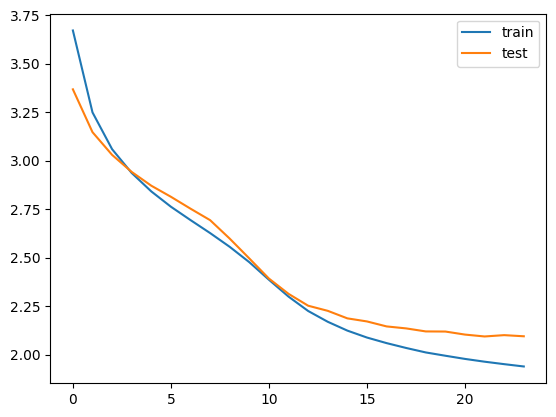

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


 seq2seq + attention으로 요약 모델 테스트하기

In [57]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [58]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])


In [59]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [60]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [61]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [62]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence


In [63]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("rouge scores: ",rouge.get_scores(decode_sequence(encoder_input_test[1].reshape(1, text_max_len)), seq2summary(decoder_input_test[1]) , avg= True))
    print("\n")


원문 :  이러 정책 실행 또는 구현 주체 로서 교사 대한 개념 정책 자체 정책 정책 위치 맥락 강조 이론 연구 분석 연구 모형 도출 어서 중요 시사점 준다고 정책 구현 과정 발생 요인 알고리즘 형식 제시 어렵 다고 지적 한다 때문 정책 구현 과정 모형 학교 현장 정책 행위 주체 활동 포괄 제시 유의미 사태 유기 관련 구현 과정 활동 해석 번역 따른 변화 명확히 포착 못하 으며 번역 해석 과정 가시 강조 못하 다는 한계 
실제 요약문 : 정책 실행 구현 주체 교사 개념 정책 자체 위치 강조 이론 연구 중요 시사점 준다 
1/1 [==============================] - 0s 10ms/step
예측 요약문 :  정책 실행 또는 구현 주체 로서 교사 개념 정책 위치 맥락 강조 이론 연구 분석 연구 모형 도출


원문 :  교육 정책 실행 영향 미치 요인 규명 사례 메타 분석 실시 사례 메타 분석 개별 사례 중심 연구 체계 종합 방법 이혜영 정책 실행 관련 연구 주로 단일 정책 사례 중심 이루어지 때문 연구 결과 일반 이론 한계 보여 다는 비판 극복 위한 방안 활용 방법론 사례 메타 분석 정책 분석 목적 개발 사례 다루 정책 실행 요인 이론 위해 활용 단일 사례 연구 가지 풍부 유지 단일 사례 연구 체계 종합 일반 가능 높이 위한 방법론 이혜영 특히 연구 교육 정책 학교 현장 실현 과정 밝힘 교육 정책 실행 영향 미치 요인 추출 통해 일반 교육 정책 실행 모형 도출 목적 사례 메타 분석 다양 교육 정책 대상 교육 정책 실행 영향 요인 다루 개별 연구 일반 교육 정책 실행 영향 요인 추출 적합 방법 라고 
실제 요약문 : 교육 정책 실행 영향 요인 규명 위하 사례 메타 분석 실시 는데 분석 방법 정책 실행 관련 연구 한계 극복 위한 방안 단일 사례 연구 체계 종합 일반 가능 높이 위한 방법론 연구 일반 교육 정책 실행 모형 도출 목적 적합 방법 
1/1 [==============================] - 0s 1ms/step
예측 요약문

In [ ]:
import nltk.translate.bleu_score as bleu
print('실습 코드의 BLEU :',bleu_score(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).split(),list(map(lambda ref: ref.split(), seq2text(encoder_input_test[i])))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).split()))

In [64]:
# df2 =pd.read_csv('C:/Users/User/Downloads/도서자료 요약/Validation/[원천]도서요약_valid/validation_data.csv')

In [68]:
model.save('model1.h5')

In [66]:
# df['passage'][:10]
# for i in df['passage'][:10]:
    


IndentationError: expected an indented block (1528317576.py, line 3)

In [67]:
def remove_duplicates(input_file_path, output_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 중복된 내용을 제거하기 위해 set을 활용
    unique_lines = set()

    # 중복이 없는 경우와 중복이 발생하는 경우를 구분해서 저장
    non_duplicate_lines = []
    duplicate_lines = []

    for line in lines:
        # 라인 내의 앞뒤 공백 제거하여 비교
        cleaned_line = line.strip()
        if cleaned_line not in unique_lines:
            non_duplicate_lines.append(line)
            unique_lines.add(cleaned_line)
        else:
            duplicate_lines.append(line)

    # 중복이 없는 라인들을 파일에 저장
    with open(output_file_path, 'w', encoding='utf-8') as file:
        file.writelines(non_duplicate_lines)

    # 중복된 라인들은 리스트 형태로 반환
    return duplicate_lines

# 텍스트 파일 경로 지정
input_file_path = "C:\\Users\\User\\Desktop\\새 텍스트 문서 (2).txt"
output_file_path = "C:\\Users\\User\\Desktop\\새 텍스트 문서 (2)_noduplicates.txt"

# 중복 제거 및 중복된 라인들 반환
duplicate_lines = remove_duplicates(input_file_path, output_file_path)

# 중복된 라인들 출력
print("중복된 라인들:")
print("".join(duplicate_lines))


중복된 라인들:

아
휴
아이구
아이쿠
아이고
어
나
우리
저희
따라
의해
을
를
에
의
가
으로
로
에게
뿐이다
의거하여
근거하여
입각하여
기준으로
예하면
예를 들면
예를 들자면
저
소인
소생
저희
지말고
하지마
하지마라
다른
물론
또한
그리고
비길수 없다
해서는 안된다
뿐만 아니라
만이 아니다
만은 아니다
막론하고
관계없이
그치지 않다
그러나
그런데
하지만
든간에
논하지 않다
따지지 않다
설사
비록
더라도
아니면
만 못하다
하는 편이 낫다
불문하고
향하여
향해서
향하다
쪽으로
틈타
이용하여
타다
오르다
제외하고
이 외에
이 밖에
하여야
비로소
한다면 몰라도
외에도
이곳
여기
부터
기점으로
따라서
할 생각이다
하려고하다
이리하여
그리하여
그렇게 함으로써
하지만
일때
할때
앞에서
중에서
보는데서
으로써
로써
까지
해야한다
일것이다
반드시
할줄알다
할수있다
할수있어
임에 틀림없다
한다면
등
등등
제
겨우
단지
다만
할뿐
딩동
댕그
대해서
대하여
대하면
훨씬
얼마나
얼마만큼
얼마큼
남짓
여
얼마간
약간
다소
좀
조금
다수
몇
얼마
지만
하물며
또한
그러나
그렇지만
하지만
이외에도
대해 말하자면
뿐이다
다음에
반대로
반대로 말하자면
이와 반대로
바꾸어서 말하면
바꾸어서 한다면
만약
그렇지않으면
까악
툭
딱
삐걱거리다
보드득
비걱거리다
꽈당
응당
해야한다
에 가서
각
각각
여러분
각종
각자
제각기
하도록하다
와
과
그러므로
그래서
고로
한 까닭에
하기 때문에
거니와
이지만
대하여
관하여
관한
과연
실로
아니나다를가
생각한대로
진짜로
한적이있다
하곤하였다
하
하하
허허
아하
거바
와
오
왜
어째서
무엇때문에
어찌
하겠는가
무슨
어디
어느곳
더군다나
하물며
더욱이는
어느때
언제
야
이봐
어이
여보시오
흐흐
흥
휴
헉헉
헐떡헐떡
영차
여차
어기여차
끙끙
아야
앗
아야
콸콸
졸졸
좍좍
뚝뚝
주룩주룩
솨
우르르
그래도
또
그리고
바꾸어말하면
바꾸어말하자면
혹은
혹시
답다
및
그에 따르는
때가 되어
즉
지든지
설령
가령
하더라도
할지라도
일지라도
지든지
몇
거의
하마터면
인젠
